In [1]:
import sklearn.metrics
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from collections import OrderedDict

import  matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [2]:
def L2norm(stat):
    return(np.sqrt(stat**2))

def matrix_inv(matrix):
    return np.linalg.pinv(matrix)


In [3]:
class msetLR_covariance_scaler() :
    
    def __init__(self) :
        
        self.cov_inv_matrix = None
            
    def fit(self, trdat):
        
        cov_mat = np.cov(trdat.transpose())
        self.cov_inv_matrix = matrix_inv(cov_mat)
        
    def transform(self, tsdat) :
        if isinstance(tsdat, list) :
            tsdat = np.array(tsdat).transpose()
            
        scaled_residual = np.dot(np.array(tsdat), self.cov_inv_matrix)
        return scaled_residual

In [4]:
def bootstrap_limit(stat, alpha=0.05, bootstrap=100, upper = True):
    '''
        @Description
            Bootstrap sampling을 활용한 Control Limit 산출 기법

        @Parameter
            stat : 통계량 (정상상태의 데이터 입력)
            alpha : Control Limit을 정하기 위한 유의수준 (0~1)
            bootstrap : 샘플링 횟수
        @Return
            limit : 임계값 (CL : Control Limit)
    '''
    
    alpha = alpha * 100
    if(upper) : alpha = 100 - alpha
    samsize = max(100, len(stat))
    
    stat = stat.reshape(len(stat)) # 2차원 array를 1차원 array로 변환
    
    # bootstrap 수 만큼 다음 작업을 반복 : samsize(최소 10000번)만큼 정상상태 데이터를 유의수준 만큼 복원 추출 후 평균 값 사용 
    limit = np.mean(list(map(lambda x:np.percentile(np.random.choice(stat,samsize,replace=True),alpha), range(0,bootstrap))))
    
    return limit

In [5]:
# 오토인코더 모듈 정의
class Autoencoder(nn.Module):
    def __init__(self,X):
        super(Autoencoder, self).__init__()
        data_size = X.size(1)
        self.UCL = None
        self.LCL = None
        self.varucl = []
        self.varlcl = []
        
        self.encoder = nn.Sequential( 
            nn.Linear(data_size, 128), 
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 4),   
        )
        self.decoder = nn.Sequential(
            nn.Linear(4, 12), 
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, data_size),       
        )

    def fit(self, epochs, loader, criterion, optimizer):        
        
        for epoch in range(epochs):
            for step ,(x) in enumerate(loader):
                x = x[0]
                y = x
                encoded =  self.encoder(x)
                decoded =  self.decoder(encoded)
                loss = criterion(decoded , y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    
    
    def CL_printor(self) :
        """
        
        Returns
        -------
        UCL, LCL: float
            upper, lower Control Limit,
        varUCL, varLCL :
            변수 별  UCL, LCL
            
        """
        
        return {'UCL' : self.UCL, 'LCL' : self.LCL, 'varUCL' : self.varucl, 'varLCL' : self.varlcl}
    
    def predict(self, x):
        encoded = self.encoder(x) 
        decoded = self.decoder(encoded)  
        
        
        return  decoded 
                

In [6]:
class adAutoenocder(nn.Module):
    
    def __init__(self, trdat):
        super(adAutoenocder, self).__init__()
        trdat= torch.tensor(trdat)
        data_size = trdat.size(1)
        self.UCL = None
        self.LCL = None
        self.varucl = []
        self.varlcl = []
        self.scaler = StandardScaler()
        self.model = Autoencoder(trdat)
       
    def fit(self, trdat, alpha, epochs, loader, criterion, optimizer):
        """

        Parameters
        ----------
        trdat : array
            학습 데이터

        Returns
        -------
        trScore : array
            Autoencoder의 Train reconstruction error (이상감지 통계량)

        """
        
        self.scaler.fit(trdat)
        trdat = self.scaler.transform(trdat)
        
        # 데이터를 파이토치 텐서로 변경
        trdat_torch = torch.Tensor(trdat)
        
        # 학습을 위한 데이터 전처리 
        dataset = TensorDataset(trdat_torch)
        loader= DataLoader(dataset, batch_size=1, shuffle = True)
        
        #CL을 선정하기위한 신경망 생성하기 
        optimizer = torch.optim.Adam(self.model.parameters(), lr = 0.005)
        criterion = nn.MSELoss()
        self.model.fit(epochs, loader, criterion, optimizer)
        
        # Training Reconstruction Error (TrScore)
        pred_trdat = self.model.predict(trdat_torch)
        trReconError = pred_trdat - trdat_torch
        trReconError = trReconError.detach().numpy()
              
        # Trscore rowsum
        trScore = L2norm(trReconError).sum(axis = 1) # L2norm

        ## CL
        # 각 변수 별 CL
        for i in range(trdat.shape[1]):
            self.varucl.append(bootstrap_limit(trReconError[:, i], alpha=alpha/2))
            self.varlcl.append(bootstrap_limit(trReconError[:, i], alpha=alpha/2, upper=False))
        
        # UCL = LCL
        self.UCL = bootstrap_limit(trScore, alpha = alpha)
        self.LCL = self.UCL
    
        return {'trScore' : trScore, 'varTrScore' : trReconError}
    
    def CL_printor(self) :
        """
        
        Returns
        -------
        UCL, LCL: float
            upper, lower Control Limit,
        varUCL, varLCL :
            변수 별  UCL, LCL
            
        """
        
        return {'UCL' : self.UCL, 'LCL' : self.LCL, 'varUCL' : self.varucl, 'varLCL' : self.varlcl}

    def predict(self, tsdat) :
        """

        Parameters
        ----------
        tsdat : array
            예측 데이터

        Returns
        -------
        tsScore : array
            Autoencoder의 Test reconstruction error (이상감지 통계량)

        """
        tsdat = self.scaler.transform(tsdat)
        tsdat_tensor = torch.tensor(tsdat).float()
        # Testing Reconstruction Error (TrScore)
        pred_tsdat = self.model.predict(tsdat_tensor)
        tsReconError = pred_tsdat - tsdat_tensor
        tsReconError = tsReconError.detach().numpy()
        
        # Row Sum
        tsScore = L2norm(tsReconError).sum(axis = 1) # L2norm
        
        return {'tsScore' : tsScore, 'varTsScore' : tsReconError}

In [7]:
def AE(trdat, tsdat, epochs=1, alpha=0.05):
    """

        Parameters
        ----------
        tsdat : array
            학습 데이터

        tsdat : array
            예측 데이터
            
        epochs : int
            오토인코더 학습 횟수

        alpha : float
            control limit 유의수준


        Returns
        -------
        trScore : array
            Autoencoder의 Train reconstruction error (이상감지 통계량)
            
        tsScore : array
            Autoencoder의 Test reconstruction error (이상감지 통계량)
        
        varTrScore : array
            변수 별 Autoencoder의 Train reconstruction error (이상감지 통계량)
            
        varTsScore : array
            변수 별 Autoencoder의 Test reconstruction error (이상감지 통계량)
            
        UCL : float
            tsScore의 control limit
            
        LCL : float
            tsScore의 control limit
            
        varUCL : list
            변수 별 tsScore의 control limit(Upper)
            
        varLCL : list
            변수 별 tsScore의 control limit(Lower)


    """
    if isinstance(trdat, pd.DataFrame) :
        trdat = trdat.values
    adAE = adAutoenocder(trdat)
    
    # 학습을 위한 데이터 전처리 
    dataset = TensorDataset(torch.tensor(trdat))
    loader= DataLoader(dataset, batch_size=1, shuffle = True)
    optimizer = torch.optim.Adam(adAE.model.parameters(), lr = 0.005)
    criterion = nn.MSELoss()

    fit = adAE.fit(trdat, alpha, epochs, loader, criterion, optimizer)
    CL = adAE.CL_printor()
    
    if isinstance(tsdat, pd.DataFrame) :
        tsdat = tsdat.values
    pred = adAE.predict(tsdat)
    
    # save Autoencoder model
    saved_model = joblib.dump(adAE, 'AE.pkl')
    
    return {'trScore' : fit['trScore'], 'tsScore' : pred['tsScore'], 'UCL' : CL['UCL'], 'LCL' : CL['LCL'],
            'varTrScore' : fit['varTrScore'], 'varTsScore' : pred['varTsScore'], 'varUCL' : CL['varUCL'], 'varLCL' : CL['varLCL']}

In [8]:
# Testing Model load
import joblib
def AE_model_loader(pickleFile, tsdat) :
    """
    저장한 모델을 로드한 후, 로드한 모델과 데이터를 활용해 분석 결과 리턴

    Parameters
    ----------
    model : ?
        로드한 모델
    tsdat : array
        예측 데이터

    Returns
    -------
    모델 리턴과 동일

    """
    
    model = joblib.load(pickleFile)  
    CL = model.CL_printor()
    if isinstance(tsdat, pd.DataFrame) :
        tsdat = tsdat.values
    pred = model.predict(torch.tensor(tsdat))

    return {'tsScore' : pred['tsScore'], 'UCL' : CL['UCL'], 'LCL' : CL['LCL'],
            'varTsScore' : pred['varTsScore'], 'varUCL' : CL['varUCL'], 'varLCL' : CL['varLCL']}

In [9]:
df = pd.read_csv('test_data.csv', encoding='euc-kr')
trdat = df.iloc[0:600,:]
tsdat = df.iloc[600:800, :]

In [10]:
pred = AE(trdat, tsdat, epochs=50, alpha=0.05)

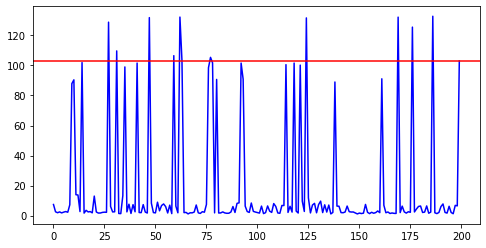

In [11]:
plt.figure(figsize=(8,4))
plt.plot(pred['tsScore'], color='blue')
plt.axhline(y=pred['UCL'], color='red')
plt.show()

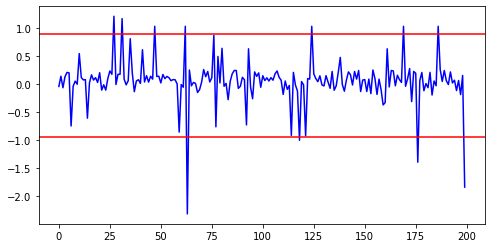

In [12]:
plt.figure(figsize=(8,4))
plt.plot(pred['varTsScore'][:,3], color='blue')
plt.axhline(y=pred['varUCL'][3], color='red')
plt.axhline(y=pred['varLCL'][3], color='red')
plt.show()

In [13]:
load = AE_model_loader('AE.pkl', tsdat)